# Install

In [24]:
import os
os.chdir('./GymGo-master')

In [25]:
! pip install -e .

Obtaining file:///Users/yuetongliu/Desktop/Reinforcement_Learning_on_Go/Code/14_02_24_Go/GymGo-master
  Attempting uninstall: gym-go
    Found existing installation: gym-go 0.0.1
    Uninstalling gym-go-0.0.1:
      Successfully uninstalled gym-go-0.0.1
  Running setup.py develop for gym-go


# Baseline with different size

1000 simulation on board 3*3, 5*5, and 7*7
According to the density plot, the game is biased on black size but the bias decreases as the size of the board increase. Moreover, komi, a bias score constant to balance the advantage of black going first.

In [33]:
import gym

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from collections import defaultdict
import random

In [28]:
win_3 = []
diff_3 = []
win_5 = []
diff_5 = []
win_7 = []
diff_7 = []
for i in range(1000):
    # Initialize environment
    go_env3 = gym.make('gym_go:go-v0', size=3, reward_method = "heuristic")
    go_env5 = gym.make('gym_go:go-v0', size=5, reward_method = "heuristic")
    go_env7 = gym.make('gym_go:go-v0', size=7, reward_method = "heuristic")

    # 3*3
    done = False
    while not done:
    #go_env.render(mode="terminal")
    # black
        action = go_env3.uniform_random_action()
        state, reward, done, info = go_env3.step(action)
        diff_3.append(reward/9)
        
        if go_env3.game_ended():
            break
        
    # white    
        action = go_env3.uniform_random_action()
        state, reward, done, info = go_env3.step(action)
    
    # winning rate 
    if reward > 0:
        win_3.append(1)
    elif reward <0:
        win_3.append(-1)
    else:
        win_3.append(0)
    
    # 5*5
    done = False
    while not done:
    #go_env.render(mode="terminal")
    # black
        action = go_env5.uniform_random_action()
        state, reward, done, info = go_env5.step(action)
        diff_5.append(reward/25)
        
        if go_env5.game_ended():
            break
        
    # white    
        action = go_env5.uniform_random_action()
        state, reward, done, info = go_env5.step(action)
        
    if reward > 0:
        win_5.append(1)
    elif reward <0:
        win_5.append(-1)
    else:
        win_5.append(0)
    
    # 7*7
    done = False
    while not done:
    #go_env.render(mode="terminal")
    # black
        action = go_env7.uniform_random_action()
        state, reward, done, info = go_env7.step(action)
        diff_7.append(reward/49)
        if go_env7.game_ended():
            break
        
    # white    
        action = go_env7.uniform_random_action()
        state, reward, done, info = go_env7.step(action)
    if reward > 0:
        win_7.append(1)
    elif reward <0:
        win_7.append(-1)
    else:
        win_7.append(0)    

In [29]:
len(diff_3),len(diff_5),len(diff_7)


(7568, 19286, 37628)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

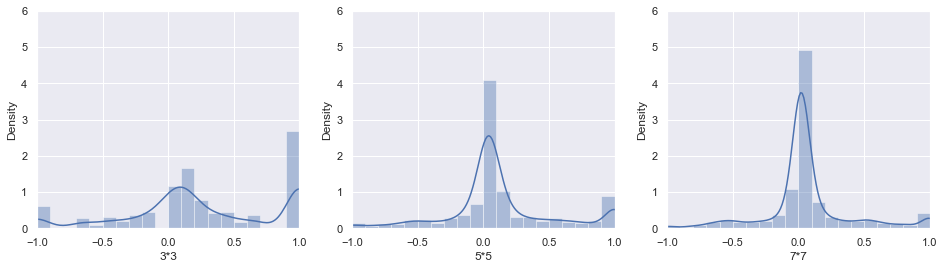

In [34]:
diff_3_ = random.sample(diff_3,7000)
diff_5_ = random.sample(diff_5,7000)
diff_7_ = random.sample(diff_7,7000)

sns.set(rc={"figure.figsize": (16, 4)}); 

subplot(1,3,1)
ax = sns.distplot(diff_3_,bins=20)
plt.xlabel("3*3")
plt.xlim(-1,1)
plt.ylim(0,6)

subplot(1,3,2)
ax = sns.distplot(diff_5_,bins=20)
plt.xlabel("5*5")
plt.xlim(-1,1)
plt.ylim(0,6)

subplot(1,3,3)
ax = sns.distplot(diff_7_,bins=20)
plt.xlabel("7*7")
plt.xlim(-1,1)
plt.ylim(0,6)

plt.show()

These three density plot is the intermediate reward for each board during 1000 simulations. 
The reward is normalized into range (-1, 1).

In [311]:
print(win_3.count(1),win_3.count(-1),win_3.count(0))
print(win_5.count(1),win_5.count(-1),win_5.count(0))
print(win_7.count(1),win_7.count(-1),win_7.count(0))

516 484 0
528 472 0
514 486 0


# Naive Q Learning

In [359]:


Q = defaultdict(float)

gamma = 0.99  # Discounting factor
alpha = 0.5  # soft update param
#actions = range(env.action_space.n) # all possible actions

# Calculate Q Value    
def update_Q(s, r, a, s_next, done, actions):
    # s: observations
    # r: reward 
    # a: actions
    # s_next: same as s
    # done: bool
    
    max_q_next = max([Q[s_next, a] for a in actions])  # get max Q value of (s', a')
    
    # Do not include the next state's value if currently at the terminal state.
    Q[s, a] += alpha * (r + gamma * max_q_next * (1.0 - done) - Q[s, a]) # the Bellman equation to update Q value. 
    # If done is True, Q(s,a) = (1-alpha)*Q(s,a)


In [360]:
epsilon = 0.1  # 10% chances to apply a random action

def act(ob,actions): 
    if np.random.random() < epsilon:
        # action_space.sample() is a convenient function to get a random action
        # that is compatible with this given action space.
        return go_env.uniform_random_action()

    # Pick the action with highest q value.
    qvals = {a: Q[ob, a] for a in actions}
    max_q = max(qvals.values())  # get best Q value 
    # In case multiple actions have the same maximum q value.
    actions_with_max_q = [a for a, q in qvals.items() if q == max_q] # range(2); max_q
    return np.random.choice(actions_with_max_q)

In [361]:
def moves(a,size): 
    if a == size**2:
        return None
    else:
        return([int(np.floor(a/size)),a%size])      

# Simulation

In [362]:
diff = []
win =[]
size = 5

    # Game loop
for i in range(1000): 
    go_env = gym.make('gym_go:go-v0', size=size, reward_method = "heuristic")
    done = False
    
    while not done:
    #go_env.render(mode="terminal")
    # black
        ob = go_env.state_
        ob = int("".join(str(x) for x in np.intc(ob.flatten())), 2)
       #actions = moves(go_env.valid_moves())
        a = act(ob, np.argwhere(go_env.valid_moves()).flatten().tolist())
    
        state, r, done, info = go_env.step(moves(a,size))
        ob_next = go_env.state_
        ob_next = int("".join(str(x) for x in np.intc(ob_next.flatten())), 2) 
        #actions = moves(go_env.valid_moves())
        update_Q(ob, r, a, ob_next, done, np.argwhere(go_env.valid_moves()).flatten().tolist())
    
        diff.append(reward/size**2)
        if go_env.game_ended():
            break
        
    # white    
        action = go_env.uniform_random_action()
        state, reward, done, info = go_env.step(action)
        
    if reward > 0:
        win.append(1)
    elif reward <0:
        win.append(-1)
    else:
        win.append(0)
        
    


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


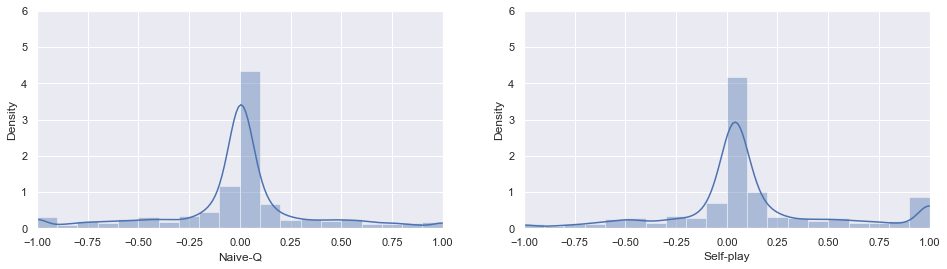

In [364]:
sns.set(rc={"figure.figsize": (16, 4)}); 

subplot(1,2,1)
ax = sns.distplot(diff,bins=20)
plt.xlabel("Naive-Q")
plt.xlim(-1,1)
plt.ylim(0,6)

subplot(1,2,2)                           
ax = sns.distplot(diff_5,bins=20)
plt.xlabel("Self-play")
plt.xlim(-1,1)
plt.ylim(0,6)

plt.show()

In [353]:
print(win.count(1),win.count(-1),win.count(0))
print(win_5.count(1),win_5.count(-1),win_5.count(0))

5122 4651 227
528 472 0


The expected value of intermidiate reward doesn't have a signification increase, even if the I increase the number of simulation. However, it reduces the bias by letting the black play first.
TODO: optimize algorithm, try it on smaller board, tune hyperparamster.